In [1]:
import pandas as pd
from tqdm import tqdm ## barrra de progreso
import datetime as dt ## cosas de fechas
import numpy as np ## algebra lineal
import os ### crear/borrar carpetas
from datetime import timedelta ## cosas fechas, 
import warnings
warnings.filterwarnings('ignore') 

pd.set_option('display.max.columns',150)
pd.set_option('display.max.rows',150)

from google.cloud import bigquery
from google.oauth2 import service_account

In [2]:
bq_client = bigquery.Client()

## <font color = '#004D9E'> Segmentos en los que se particionan los Usuarios con LCA

In [4]:
import time
a = time.time()

query_job = bq_client.query(f"""
SELECT icu As ICU, segmento
FROM `gs-mx-sandboxconsumo-dev.DPBV_10048652.sh_remesas_segmentos`
""")
results = query_job.result() 
seg_rem = query_job.to_dataframe()

b = time.time()

print(seg_rem.shape[0])
print(f"{b-a}, segs")
seg_rem.head(2)

487002
3.965196371078491, segs


,ICU,segmento
0,a9578a9d616c4d64af3244fc95ae8d67,1
1,eb5a0de494bc4b0da3c1f2e61fc9fe9d,1


In [18]:
seg_rem.segmento.value_counts()

segmento
5    200413
3    102666
4     74672
2     67799
1     36766
Name: count, dtype: Int64

## <font color = '#004D9E'> Puerta Trasera

In [10]:
import time
a = time.time() # 

query = bq_client.query(f"""
SELECT DISTINCT icu AS ICU , segmento_di
FROM `bancadigital-539f1.Shopinbaz_Backdoor.final10k_2` A
""")

puerta = query.to_dataframe()
print(puerta.shape[0])

b = time.time()
print(f"{b-a:,.2f} seg")

10189875
18.47 seg


## <font color = '#004D9E'> Usuarios con Compras Previas.

In [11]:
from tqdm import tqdm
import time

icu_list = seg_rem["ICU"].unique().tolist()
batch_size = 25000

icu_batches = [icu_list[i:i + batch_size] for i in range(0, len(icu_list), batch_size)]
compras_final = pd.DataFrame()

# Configuración de tqdm para una barra más limpia
with tqdm(icu_batches, desc="Procesando lotes", unit="lote",ncols=100,bar_format="{l_bar}{bar:50}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}{postfix}]") as pbar:
    for batch in pbar:
        start_time = time.time()
        
        icu_str = ",".join([f"'{icu}'" for icu in batch])

        query = f"""
            SELECT DISTINCT icu as ICU, 
            monto_total_pedido AS monto, 
            fecha_generacion AS fecha
            FROM `gs-mx-sandboxconsumo-dev.boletin_sbxgs_cleaned.crystal_compras_ecommerce`        
            WHERE plataforma = "BancaDigital"
            AND compra_exitosa = TRUE
            AND forma_pago LIKE '%dito'
            AND icu IN ({icu_str})
        """

        query_job = bq_client.query(query)
        compras_batch = query_job.result().to_dataframe()

        compras_final = pd.concat([compras_final, compras_batch], ignore_index=True)
        
        end_time = time.time()
        pbar.set_postfix_str(f"Último lote: {len(batch)} ICU en {end_time - start_time:.2f}s")

compras_final = compras_final[~compras_final.monto.isnull()]
compras_final['fecha_compra'] = compras_final.fecha.astype(str).str[:10]

compras_final.head(1)

Procesando lotes: 100%|██████████████████████████████████████████████████| 20/20 [03:18<00:00,  9.93


,ICU,monto,fecha,fecha_compra
0,7cb2447722bf45f989e052a9324db38d,11999.0,2024-12-22 17:54:51.905,2024-12-22


## <font color = '#004D9E'> Cálculo Tasas P y G Hist

In [12]:
# porcentaje de usuarios que ya habíam comprado
### OJO: Puede que ya hayan quitado algunos antes de ingestar la tabla, por lo que
### si es el caso aumentaría
tasa_part = compras_final.ICU.nunique()/seg_rem.ICU.nunique()
tasa_gan = compras_final[compras_final.monto >= 800].ICU.nunique()/seg_rem.ICU.nunique()

In [13]:
compras_final['fecha_compra'] = pd.to_datetime(compras_final['fecha_compra'])

compras_final['año'] = compras_final['fecha_compra'].dt.isocalendar().year
compras_final['semana'] = compras_final['fecha_compra'].dt.isocalendar().week

total_icu_seg_rem = seg_rem.ICU.nunique()

tasas_ganadores = (
    compras_final[compras_final['monto'] >= 800]
    .groupby(['año', 'semana'])
    .agg({'ICU': 'nunique'})
    .rename(columns={'ICU': 'icu_unicos'})
    .reset_index()
)

tasas_ganadores['tasa_G'] = tasas_ganadores['icu_unicos'] / total_icu_seg_rem
tasas_ganadores['Hubieran_Sido_Gan'] = tasas_ganadores['tasa_G'] *35000
tasas_ganadores = tasas_ganadores[['año', 'semana',  'tasa_G', 'Hubieran_Sido_Gan']]

tasas_ganadores = tasas_ganadores.sort_values(['año', 'semana'])

In [14]:
tasas_part = (
    compras_final
    .groupby(['año', 'semana'])
    .agg({'ICU': 'nunique'})
    .rename(columns={'ICU': 'icu_unicos'})
    .reset_index()
)

tasas_part['tasa_P'] = tasas_part['icu_unicos'] / total_icu_seg_rem
tasas_part['Hubieran_Sido_Part'] = tasas_part['tasa_P'] *34643
tasas_part = tasas_part[['año', 'semana',  'tasa_P', 'Hubieran_Sido_Part']]

tasas_part = tasas_part.sort_values(['año', 'semana'])

In [15]:
tasas_e = tasas_ganadores.merge(tasas_part, on=['año','semana'], how = 'left')

In [16]:
seg_rem = seg_rem[(~seg_rem.ICU.isin(compras_final.ICU)) & (seg_rem.ICU.isin(puerta.ICU))] 

In [17]:
seg_rem.columns

Index(['ICU', 'segmento'], dtype='object')

## <font color = '#004D9E'> Muestreo y Bootstrap

**NOTA:**

$$
X_i^{k}\sim Bernoulli(p) \Rightarrow \frac{1}{n} \displaystyle{\sum_{i=1}^{n}X_i} = \hat{p} \sim N\left(p,\displaystyle{\sqrt{\frac{p(1-p)}{n}}}\right)
$$

Fórmula para intervalos de confianza de una proporción

$$
IC \approx \hat{p} \,\pm z_{\alpha/2} \displaystyle{\sqrt{\frac{\hat{p}(1-\hat{p})}{n}}}
$$

Amplitud del IC *(que tando se "abre")* 

$$
E = z_{\alpha/2} \displaystyle{\sqrt{\frac{\hat{p}(1-\hat{p})}{n}}}
$$

Despejando $n$

$$
n = \displaystyle{\frac{z_{\alpha/2}^2 \cdot \hat{p}(1-\hat{p})}{E^2}}
$$

In [19]:
from scipy.stats import norm

def calcular_tamaño_muestra(poblacion_total, p_k, margen_error=0.05, confianza=0.95):
    """Calcula el tamaño de muestra para un segmento con proporción p_k."""
    z = norm.ppf(1 - (1 - confianza) / 2)  # Valor Z
    n = (z**2 * p_k * (1 - p_k)) / (margen_error**2)
    
    # Ajuste para población finita
    n_ajustado = n / (1 + (n - 1) / poblacion_total)
    return int(np.ceil(n_ajustado))



In [20]:
proporciones = seg_rem['segmento'].value_counts(normalize=True)
margen_error = 0.005  #  amplitud del intervalo de confianza
confianza = 0.95      # 95% de confianza
poblacion_total = len(seg_rem)
resultados = []

for segmento, p_k in proporciones.items():
    n_k = calcular_tamaño_muestra(poblacion_total, p_k, margen_error, confianza)
    resultados.append({
        'segmento': segmento,
        'proporcion': p_k,
        'tamaño_muestra': n_k
    })

In [21]:
tm = pd.DataFrame(resultados)
tm

,segmento,proporcion,tamaño_muestra
0,5,0.415522,34639
1,3,0.212860,24442
2,4,0.154820,19302
3,2,0.140570,17876
4,1,0.076228,10583


In [22]:
tm.tamaño_muestra.max()

34639

In [23]:
tm.tamaño_muestra.sum()

106842

In [24]:
proporciones_reales = seg_rem['segmento'].value_counts(normalize=True).sort_index()

def Bootstrap(df, columna_segmento, n_muestra, n_simulaciones=1000, guardar_como=None, calcular_intervalos=False):
    """
    Simula múltiples muestras y compara proporciones con las reales.
    
    Args:
        df (pd.DataFrame): DataFrame con los datos originales
        columna_segmento (str): Nombre de la columna con los segmentos
        n_muestra (int): Tamaño de cada muestra
        n_simulaciones (int): Número de muestras a simular (default=1000)
        guardar_como (str): Nombre para guardar el resultado en el kernel (opcional)
        calcular_intervalos (bool): Genera los intervalos Interpercentilicos (opcional)
    
    Returns:
        pd.DataFrame: DataFrame comparativo con proporciones reales vs muestrales
    """
    proporciones_reales = df[columna_segmento].value_counts(normalize=True).sort_index()
    
    resultados = []
    
    for _ in tqdm(range(n_simulaciones), desc="Simulando muestras", unit="muestra"):
        
        muestra = df.sample(n_muestra, replace=False, random_state=np.random.RandomState())
        
        prop_muestra = muestra[columna_segmento].value_counts(normalize=True).sort_index()
        resultados.append(prop_muestra)
    
    df_simulaciones = pd.DataFrame(resultados)
    proporciones_promedio = df_simulaciones.mean()
    
    df_comparativo = pd.DataFrame({
        'Proporción_Real': proporciones_reales,
        'Proporción_Muestral_Promedio': proporciones_promedio,
        'Diferencia_Absoluta': np.abs(proporciones_reales - proporciones_promedio)
    })
    
    if calcular_intervalos:
        df_comparativo['IC_95_inferior'] = df_simulaciones.quantile(0.025)
        df_comparativo['IC_95_superior'] = df_simulaciones.quantile(0.975)
    
    if guardar_como:
        globals()[guardar_como] = df_comparativo
    
    return print("\n\tListo!!\n")

In [40]:
Bootstrap(
    seg_rem, 
    'segmento', 
    35000,      # Tamaño de muestra 
    1000,       # número de muestras
    'propor_final',  ## nombre que tendría el dataframe
    True)
propor_final

Simulando muestras: 100%|██████████| 1000/1000 [00:15<00:00, 63.57muestra/s]



	Listo!!



,Proporción_Real,Proporción_Muestral_Promedio,Diferencia_Absoluta,IC_95_inferior,IC_95_superior
segmento,,,,,
1,0.076228,0.076206,0.000022,0.073571,0.078800
2,0.14057,0.140491,0.000079,0.137114,0.143887
3,0.21286,0.212965,0.000104,0.208829,0.217058
4,0.15482,0.154744,0.000076,0.150914,0.158401
5,0.415522,0.415594,0.000072,0.410599,0.420401


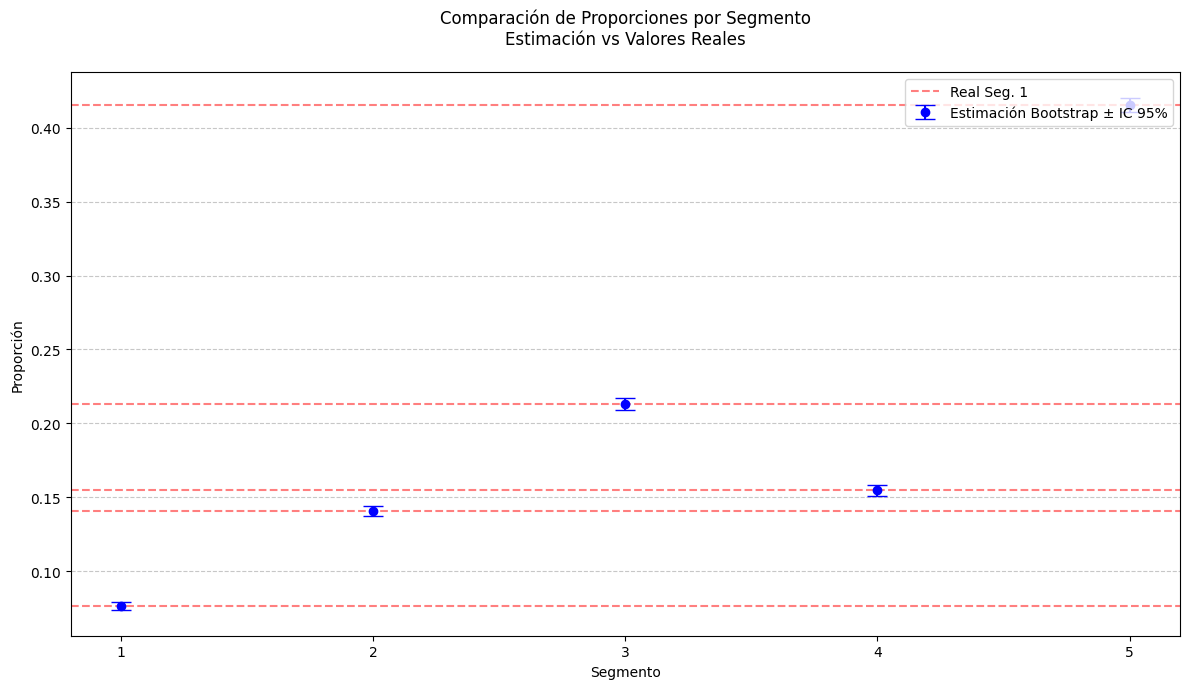

In [41]:
import matplotlib.pyplot as plt

propor_final.reset_index(inplace=True)

propor_final = propor_final.sort_values('segmento')

plt.figure(figsize=(12, 7))

plt.errorbar(
    x=propor_final['segmento'],
    y=propor_final['Proporción_Muestral_Promedio'],
    yerr=[
        propor_final['Proporción_Muestral_Promedio'] - propor_final['IC_95_inferior'],
        propor_final['IC_95_superior'] - propor_final['Proporción_Muestral_Promedio']
    ],
    fmt='o',
    capsize=7,
    color='blue',
    label='Estimación Bootstrap ± IC 95%'
)

for _, row in propor_final.iterrows():
    plt.axhline(y=row['Proporción_Real'], 
                color='red', 
                linestyle='--', 
                alpha=0.5,
                label=f'Real Seg. {row["segmento"]}' if _ == 0 else "")

plt.title('Comparación de Proporciones por Segmento\nEstimación vs Valores Reales', pad=20)
plt.xlabel('Segmento')
plt.ylabel('Proporción')
plt.xticks(propor_final['segmento']) 
plt.grid(axis='y', linestyle='--', alpha=0.7)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
tasas_e[tasas_e.año == 2025][['año', 'semana', 'tasa_G','tasa_P','Hubieran_Sido_Gan','Hubieran_Sido_Part']]

In [ ]:
0.000018 * 10000

### Proporicones Entradas

In [29]:
import time
a = time.time() # 

query = bq_client.query(f"""
SELECT DISTINCT(icu)
FROM `superapp-baz-prod.Shopinbaz_BD_curadas.Shopinbaz_ecommerce_master_events_universo`
""")

entradas = query.to_dataframe()
print(entradas.shape[0])

b = time.time()
print(f"{b-a:,.2f} seg")



5780618
11.88 seg


In [30]:
seg_rem['entrada'] = seg_rem.ICU.isin(entradas.icu).astype(int)

In [31]:
Bootstrap(
    seg_rem, 
    'entrada', 
    35000,      # Tamaño de muestra 
    1000,       # número de muestras
    'propor_final_entradas',
    True)
propor_final_entradas

Simulando muestras: 100%|██████████| 1000/1000 [00:16<00:00, 61.12muestra/s]


	Listo!!



,Proporción_Real,Proporción_Muestral_Promedio,Diferencia_Absoluta,IC_95_inferior,IC_95_superior
entrada,,,,,
0,0.347293,0.347174,0.000119,0.342571,0.351830
1,0.652707,0.652826,0.000119,0.648170,0.657429


### Se retiran audiencias de Clic, Categorias y Exp de la Puerta

In [32]:
## Excluir audiencias que genera Sonia (categoria, experimento)
categoria_1 = pd.read_csv("/home/jupyter/01.MONETIZACION/29. Campañas Categorías/Bases Perfumes-S16/Perfumes_concat.csv")
categoria_2 = pd.read_csv("/home/jupyter/01.MONETIZACION/29. Campañas Categorías/Bases Zapatos-S16/Zapatos_concat.csv")
door = pd.read_csv("/home/jupyter/01.MONETIZACION/25. Puerta/Bases-semana-S15/Concatenados-S15.csv")
clic = pd.read_csv('/home/jupyter/01.MONETIZACION/30. Intención de Compra/Audiencias/Intención_Compra_S16.csv')

In [33]:
categoria_1['camp'] = 'perfumes'
categoria_2['camp'] = 'zapatos'
door['camp'] = 'exp_puert'
clic['camp'] = 'Clic'

In [34]:
todo = pd.concat([categoria_1,categoria_2,door,clic])[['ICU','camp']]

In [35]:
todo[todo.ICU.isin(seg_rem.ICU)].camp.astype(str).value_counts()

camp
zapatos      33758
exp_puert    33419
perfumes     27969
Clic         25042
Name: count, dtype: int64

In [36]:
todo[todo.ICU.isin(seg_rem.ICU)].ICU.nunique()

120188

In [37]:
aud = seg_rem[~seg_rem.ICU.isin(todo.ICU)]

## <font color = '#004D9E'> Generación de *.csv's*

In [38]:
print(f"{len(aud):,.0f}")

362,128


In [39]:
raise ValueError("No correr lo que sigue del codigo porque genera csv's")

ValueError: No correr lo que sigue del codigo porque genera csv's

In [ ]:
N = len(aud)
aud['Grupo'] = np.random.choice(np.repeat(['no_contar', 'comms', 'control','g1'], (N-120000,40000,40000,40000)), N, replace=False)

In [ ]:
if aud.ICU.nunique() == aud.shape[0]:
    
    print("No se traslapan las audiencias")
    
else:
    raise ValueError("Se traslapan, R E V I S A R ")

In [ ]:
# Si se desea sembrar gente descomentar esta celda:

semb = {'ICU': ['d83bccb1c6064aee91878571f7387d5c', '36d9299e93a444a2beb686936958a50a',
                 '20ceb89835de4ea7883d265cd2b02c86', '7b3745da272d4636bde4c4e7e322c87e'],
         'Grupo': ['g1', 'g1', 'g1', 'g1']}
sembrados = pd.DataFrame(semb)

In [ ]:
base  = pd.concat([aud[~aud.ICU.isin(sembrados.ICU)][['ICU','Grupo']],sembrados])

In [ ]:
# base =  aud[['ICU','Grupo']]
base.shape[0], base.ICU.nunique()

In [ ]:
pwd

In [ ]:
base.to_csv(f'./Aud_Concat_S16(remesas).csv',index=False)

In [ ]:
base.Grupo.value_counts()

In [ ]:
def process_and_save(df, name):

    # Agregar columna "type" y renombrar "ICU" como "identity"
    df_modificado = df[['ICU']]  # Crear una copia para no afectar el dataframe original
    df_modificado['type'] = 'i'  
    df_modificado = df_modificado.rename(columns={'ICU': 'identity'})
 
    # Reordenar las columnas para que "type" sea la primera columna
    df_modificado = df_modificado[['type', 'identity']]
    # Guardar el dataframe modificado
    #df_modificado.to_csv(f'./SHO-HIB-1RA-S9-{name}.csv', index=False)
    df_modificado.to_csv(f'./SHO-REMESAS-1RA-S17-{name}.csv',index=False)
    ""

# Aplicar la función a los tres dataframes
process_and_save(base[base.Grupo == 'g1'], 'TRATADO')
process_and_save(base[base.Grupo == 'control'], 'CONTROL')
process_and_save(base[base.Grupo == 'comms'], 'COMMS')

In [ ]:
'/home/jupyter/01.MONETIZACION/33. Muestreo Remesas/SHO-REMESAS-1RA-S17-CONTROL.csv'

In [ ]:
pwd

In [ ]:
import pandas as pd
rem = pd.read_csv("./Aud_Concat_S16(remesas).csv")

In [ ]:
rem.Grupo.value_counts()

In [ ]:
rem[rem.Grupo != 'no_contar'].Grupo.value_counts()